# Preliminary Experiments with Existing Algorithms Part 2: In-Processing algorithm- Adversarial Debiasing

In [1]:
import sys
sys.path.append("../")
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_german

from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

import tensorflow as tf
import warnings; warnings.simplefilter('ignore')

import random
random.seed(0)

In [2]:
## import dataset
dataset_used = "german" # "adult", "german", "compas"
protected_attribute_used = 2 # 1, 2

if dataset_used == "adult":
#    dataset_orig = AdultDataset()
    dataset_orig = load_preproc_data_adult()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
    
elif dataset_used == "german":
    dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        
    for i in range(1000):
        if (dataset_orig.labels[i] == 2.0):
            dataset_orig.labels[i] = 0
        else:
            dataset_orig.labels[i] = 1
        
    dataset_orig.favorable_label = 1
    dataset_orig.unfavorable_label = 0

    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    dataset_orig = load_preproc_data_compas()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}] 

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)


#Scaling the datasets
std_scaler = StandardScaler()

#train-test split
dataset_orig_train.features = std_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = std_scaler.transform(dataset_orig_test.features)


In [3]:
#start a tesnforflow session for Adversarial Debiasing
sess = tf.Session()

# Learn parameters with debias set to True
#Debiasing Model for Adult dataset

ad_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_data_classifier',
                          debias=True,
                          sess=sess)

ad_model.fit(dataset_orig_train)

#pred_debiased_train_a = adult_model.predict(adult_orig_train)
pred_debiased_test = ad_model.predict(dataset_orig_test)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





epoch 0; iter: 0; batch classifier loss: 0.652970; batch adversarial loss: 0.486084
epoch 1; iter: 0; batch classifier loss: 0.592847; batch adversarial loss: 0.520380
epoch 2; iter: 0; batch classifier loss: 0.528856; batch adversarial loss: 0.554758
epoch 3; iter: 0; batch classifier loss: 0.485815; batch adversarial loss: 0.519924
epoch 4; iter: 0; batch classifier loss: 0.476256; batch adversarial loss: 0.523021

In [4]:
pred_debiased_test

               instance weights  features                \
                                                          
                                    month credit_amount   
instance names                                            
643                         1.0  0.230237     -0.527963   
443                         1.0 -0.748007     -0.923596   
504                         1.0  0.230237     -0.753040   
750                         1.0 -1.237129     -1.025300   
923                         1.0 -0.748007     -0.475189   
...                         ...       ...           ...   
17                          1.0  0.719359      1.646269   
704                         1.0  0.474798     -0.291352   
469                         1.0  0.230237      0.460420   
296                         1.0 -0.748007      0.459022   
722                         1.0 -0.748007     -0.745701   

                                                                \
                                                

In [5]:
#Performance Metrics from the dataset predictions

metric_debiased_test = BinaryLabelDatasetMetric(pred_debiased_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

classified_debiased_test = ClassificationMetric(dataset_orig_test, 
                                                 pred_debiased_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)


display(Markdown("#### Debiased LR with %s Test Set Fairness Performance (based on predictions)"%dataset_used))

#Checking Equalized Odds: average odds differecence, which is the avg. of differences in FPR&TPR for privileged and unprivileged groups.
deb_aeo = classified_debiased_test.average_odds_difference()
print("Average equalized odds difference between unprivileged and privileged groups = %f" % deb_aeo)

#Disparate Impact ratio between privileged and unprivileged groups.
deb_di = classified_debiased_test.disparate_impact()
print("Disparate impact ratio between unprivileged and privileged groups = %f" % deb_di)

#Demographic parity difference between privileged and unprivileged groups.
deb_spd = classified_debiased_test.statistical_parity_difference()
print("Demographic parity difference between unprivileged and privileged groups = %f" % deb_spd)

#Predictive parity difference: PPV difference between privileged and unprivileged groups.
deb_ppd = classified_debiased_test.positive_predictive_value(privileged=False) - classified_debiased_test.positive_predictive_value(privileged=True)
print("Predictive Parity difference between unprivileged and privileged groups = %f" % deb_ppd)

#Individual Fairness: 1)Consistency, 2) Euclidean Distance between individuals.
print("Consistency of indivuals' predicted labels = %f" % metric_debiased_test.consistency())


#Prediction performance metrics
TPR = classified_debiased_test.true_positive_rate() #recall
TNR = classified_debiased_test.true_negative_rate() #specificity
PPV = classified_debiased_test.positive_predictive_value() #precision
bal_acc = (TPR+TNR)/2
f1 = 2*((PPV*TPR)/(PPV+TPR))

display(Markdown("#### Debiased LR with %s Test Set Prediction Performance"%dataset_used))
print("Standard accuracy of logistic regression trained on test set with debiasing = %f" % classified_debiased_test.accuracy())
print("Balanced accuracy of logistic regression trained on test set  with debiasing = %f" % bal_acc)
print("F1 score of logistic regression trained on test set with debiasing = %f" % f1)

print("Detailed scores for %s test set"%dataset_used)
print("Precision (PPV): %f" %PPV)
print("Recall (TPR): %f" %TPR)
print("Specificity (TNR): %f" %TNR)

#### Debiased LR with german Test Set Fairness Performance (based on predictions)

Average equalized odds difference between unprivileged and privileged groups = 0.121910
Disparate impact ratio between unprivileged and privileged groups = 1.089110
Demographic parity difference between unprivileged and privileged groups = 0.066381
Predictive Parity difference between unprivileged and privileged groups = -0.122978
Consistency of indivuals' predicted labels = 0.801333


#### Debiased LR with german Test Set Prediction Performance

Standard accuracy of logistic regression trained on test set with debiasing = 0.750000
Balanced accuracy of logistic regression trained on test set  with debiasing = 0.675397
F1 score of logistic regression trained on test set with debiasing = 0.828375
Detailed scores for german test set
Precision (PPV): 0.797357
Recall (TPR): 0.861905
Specificity (TNR): 0.488889


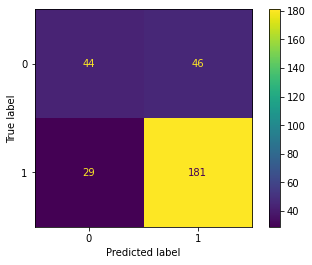

In [6]:
cm_data = confusion_matrix(dataset_orig_test.labels, pred_debiased_test.labels)

disp_data = ConfusionMatrixDisplay(confusion_matrix=cm_data)
disp_data.plot()

In [7]:
sess.close()